Here I generate 100 synthetic subjects. 75 subjects have 3 measurements (blue). 25 subjects have 2 measurements (green). For simplicity, I just assume the 2 measurements are at the first two time points. I manually modified two subjects' measurements as outliers (red and black).

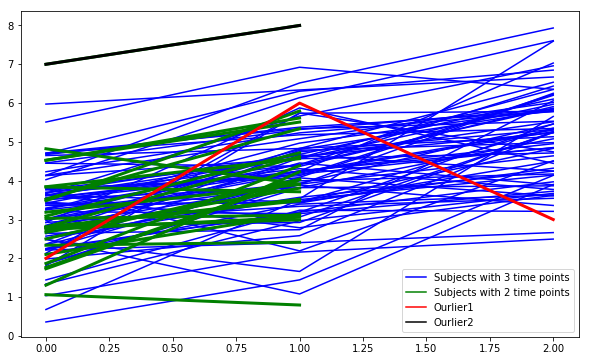

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.linalg import inv

# generate synthetic data from a 3D gaussian
mean = np.array([3,4,5])     
cov = np.matrix([[1,0.5,0.4],[0.5,1,0.5],[0.4,0.5,1]])
cov[:2, :2]

x1 = np.random.multivariate_normal(mean, cov, 75)
x2 = np.random.multivariate_normal(mean, cov, 25)
x2 = x2[:,:2]    # genearte 25 subjects with only 2 measurements

# manually create two outliers
x1[74, :] = np.array([2, 6, 3])    
x2[24, :] = np.array([7, 8])

plt.figure(figsize=(10,6))
plt.plot(x1.T,'b')
plt.plot(x2.T,'g',linewidth=3)
plt.plot(x1[74, :],'r',linewidth=3)
plt.plot(x2[24, :],'k',linewidth=3)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue'),
                Line2D([0], [0], color='green'),
                Line2D([0], [0], color='red'),
                Line2D([0], [0], color='black')]

plt.legend(custom_lines, ['Subjects with 3 time points', 
                          'Subjects with 2 time points', 
                          'Ourlier1',
                          'Ourlier2']);

To generate a multivariate distribution of the data, we need first to impute the missing values so that each subject can be represented as a 3-tuple. Here I simply fit a 3D Gaussian using the available data, i.e. computing the mean and covariance from 3D or 2D available data. Missing values can be filled in with Gaussian conditional distribution: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions 

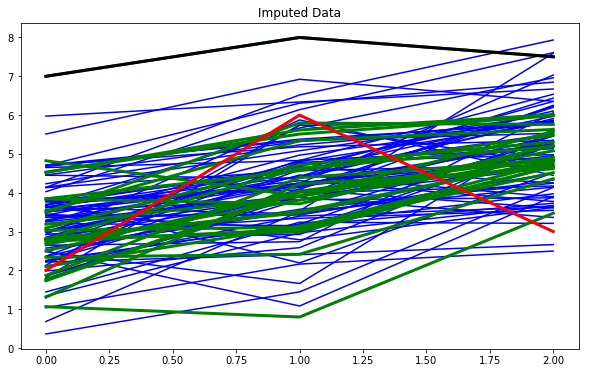

In [13]:
xFirst2Dim = np.concatenate((x1[:, :2], x2), axis = 0)

# estimate sample covariance and sample mean from existing data
covEst = np.asmatrix(np.cov(x1.T))    
covEst[:2, :2] = np.asmatrix(np.cov(xFirst2Dim.T))
meanEst = np.mean(x1, axis = 0)
meanEst[:2] = np.mean(xFirst2Dim)

# impute missing values via Gaussian conditional probability using the estimated cov and mean
missingValues = np.asarray((x2 - meanEst[:2]) * inv(covEst[:2,:2]) * covEst[:2,2] + meanEst[2])
x2Imputed = np.concatenate((x2, missingValues), axis = 1)    
xAllImputed = np.concatenate((x1,x2Imputed), axis = 0)

plt.figure(figsize=(10,6))
plt.plot(np.transpose(x1),'b')
plt.plot(np.transpose(x2Imputed),'g',linewidth=3)
plt.plot(x1[74, :],'r',linewidth=3)
plt.plot(x2Imputed[24, :],'k',linewidth=3);
plt.title('Imputed Data');

With all data in 3D and the correspdoning 3D Gaussian distribution estimated, we can compute the Mahalanobis Distance associated with all subjects. Now the data are displayed as a 3D point cloud. We can see that the data is well clustered in 3D, and more distributed along the diagonal direction. This means that the magnitude of the measurements has high variance, but subject-specific data are highly correlated longitudinally.

(0.02850564409739842, 7.331975921709648, 0.4371481432059703, 8.360135802704477)

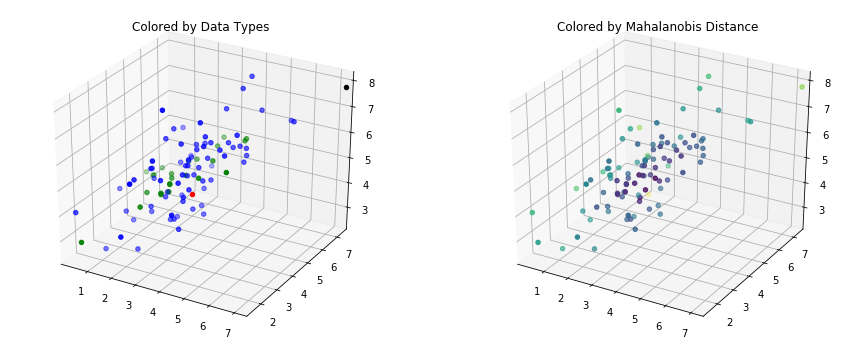

In [11]:
MDistance = []
# compute Mahalanobis distance
for i in range(0,100):
    deviation = np.asmatrix(xAllImputed[i,:] - meanEst)
    MDistance.append(np.sqrt(deviation * inv(covEst) * deviation.T))
MDistance = np.squeeze(np.asarray(MDistance))    
    
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x1[:74, 0], x1[:74, 1], x1[:74, 2], c='blue')
ax.scatter(x2Imputed[:24, 0], x2Imputed[:24, 1], x2Imputed[:24, 2], c='green')
ax.scatter(x1[74,0], x1[74,1], x1[74,2], c='red')
ax.scatter(x2Imputed[24, 0], x2Imputed[24, 1], x2Imputed[24, 2], c='black');
plt.title('Colored by Data Types')
plt.axis('equal')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(xAllImputed[:, 0], xAllImputed[:, 1], xAllImputed[:, 2], c=MDistance)
plt.title('Colored by Mahalanobis Distance')
plt.axis('equal')

Visualizing 3D data is still not intuitive. Another good way of visualizing high-dimensional data is PCA. It is clear that the first principal component is roughly along the diagonal direction, and the coordinate along that PC roughly indicates the "magnitude" of measurement. In order to have a 2D visualization, we combine the coordiantes of 2nd and 3rd PCs into one value, which represents the distance from the 3D data point to the 1st PC. This value also roughly encodes "longitudinal inconsistency" of subject-specific data.

Text(0.5,1,'Colored by Mahalanobis Distance')

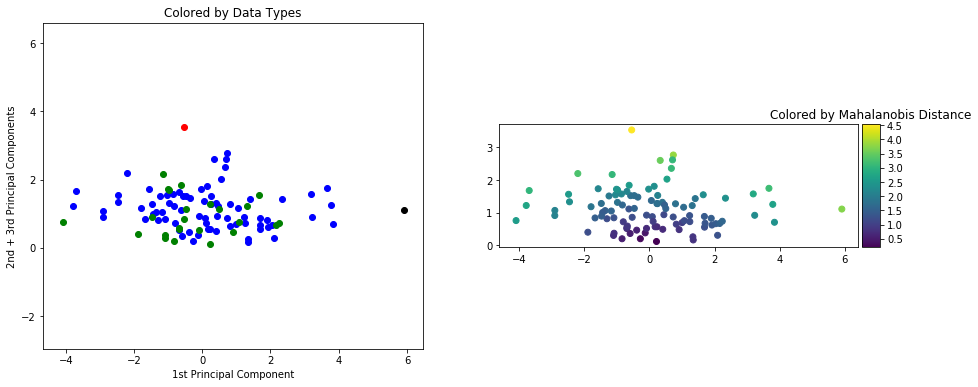

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compute PCs (eigenvectors)
w, v = LA.eig(covEst)
w, v

# project data onto the 3 PCs (a change of coordinate system)
pcScore1 = np.squeeze(np.asarray(np.dot(xAllImputed - meanEst, v[:,0])))
pcScore2 = np.squeeze(np.asarray(np.dot(xAllImputed - meanEst, v[:,1])))
pcScore3 = np.squeeze(np.asarray(np.dot(xAllImputed - meanEst, v[:,2])))

# we combine PC2 and PC3 cooridnates into one value in order to have a 2D visualization
pcScore23 = np.sqrt(np.multiply(pcScore2,pcScore2) + np.multiply(pcScore3,pcScore3))

fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
plt.scatter(pcScore1[:74], pcScore23[:74], c='blue')
plt.scatter(pcScore1[74],  pcScore23[74], c='red')
plt.scatter(pcScore1[75:99], pcScore23[75:99], c='green')
plt.scatter(pcScore1[99], pcScore23[99], c='black')
plt.title('Colored by Data Types')
plt.xlabel('1st Principal Component');
plt.ylabel('2nd + 3rd Principal Components');
plt.axis('equal')

ax = fig.add_subplot(122)
sc = plt.scatter(pcScore1, pcScore23, c=MDistance)
plt.axis('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc, cax=cax);
plt.title('Colored by Mahalanobis Distance')
